In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
vgg = VGG19(weights='imagenet', include_top=False)
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
vgg_model.trainable = False  # We don't want to train this model

def perceptual_loss(vgg_model):
    layer_outputs = [vgg_model.get_layer('block1_conv2').output,
                     vgg_model.get_layer('block3_conv3').output,
                     vgg_model.get_layer('block5_conv4').output]
    multi_layer_model = Model(inputs=vgg_model.input, outputs=layer_outputs)
    
    def loss(y_true, y_pred):
        y_true_reshaped = tf.reshape(y_true, (-1, 128, 128, 3))
        y_pred_reshaped = tf.reshape(y_pred, (-1, 128, 128, 3))

        true_features = multi_layer_model(y_true_reshaped)
        pred_features = multi_layer_model(y_pred_reshaped)

        # Compute loss for each layer and sum the losses
        loss = 0
        for true_feat, pred_feat in zip(true_features, pred_features):
            loss += tf.reduce_mean(tf.square(true_feat - pred_feat))
        
        return loss / len(true_features)  # Average the loss over layers
    
    return loss


2024-10-23 16:51:37.994883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-23 16:51:37.994904: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-23 16:51:37.994910: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-23 16:51:37.995111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-23 16:51:37.995320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def temporal_loss(y_true, y_pred):
    # Calculate difference between consecutive frames
    true_diff = y_true[:, 1:] - y_true[:, :-1]
    pred_diff = y_pred[:, 1:] - y_pred[:, :-1]
    
    # Penalize large differences
    return tf.reduce_mean(tf.square(true_diff - pred_diff))

# Combine with perceptual loss


In [4]:
def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss=[perceptual_loss(vgg), temporal_loss], loss_weights=[1, 0.1], metrics=['mae'])
    return model

In [5]:
def load_animation_data(image_folder, num_frames):
    """
    Loads animation frames from a folder and prepares separate data for the model.
    
    Parameters:
    image_folder (str): The folder containing image sequences.
    num_frames (int): The total number of frames in each animation sequence (including the input and the output frames).
    
    Returns:
    X (list): List of the first frames (input data).
    Y (list): List of lists containing the subsequent frames (output data).
    """
    # Initialize lists for input and output frames
    X = []
    Y = []
    
    # Process images according to the naming convention "frame_{i}_{frame_num}.png"
    for i in range(len(os.listdir(image_folder)) // num_frames):
        input_frame_path = os.path.join(image_folder, f"frame_{i}_0.png")
        # Load the input frame (frame_{i}_0) and convert to RGB
        input_img = Image.open(input_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
        input_array = np.array(input_img) / 255.0  # Normalize pixel values to [0, 1]
        X.append(input_array)

        # Collect outputs for this input frame
        output_frames = []
        for j in range(1, num_frames):
            output_frame_path = os.path.join(image_folder, f"frame_{i}_{j}.png")
            output_img = Image.open(output_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
            output_array = np.array(output_img) / 255.0  # Normalize pixel values to [0, 1]
            output_frames.append(output_array)
        
        # Append list of output frames for this input frame
        Y.append(output_frames)

    return np.array(X), np.array(Y)

In [6]:
def prepare_input_image(image_path):
    """
    Load and prepare a single input image for prediction.

    Parameters:
    image_path (str): Path to the input image.

    Returns:
    numpy array: Preprocessed image ready for model prediction.
    """
    # Load the image and convert to RGB
    img = Image.open(image_path).convert('RGB').resize((128, 128))
    
    # Convert image to NumPy array and normalize pixel values
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    
    # Add a batch dimension (1, 128, 128, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [7]:
def merge_frames(input_frame, output_frames):
    """
    Merge input_frame (1, 128, 128, 3) and output_frames (9, 128, 128, 3) into one array.
    
    Parameters:
    input_frame (numpy array): The first frame with shape (1, 128, 128, 3).
    output_frames (numpy array): The rest of the frames with shape (9, 128, 128, 3).

    Returns:
    numpy array: Merged frames with shape (10, 128, 128, 3).
    """
    # Remove the batch dimension from input_frame
    input_frame = np.squeeze(input_frame, axis=0)  # Shape becomes (128, 128, 3)
    
    # Concatenate the input frame with the output frames
    merged_frames = np.concatenate(([input_frame], output_frames), axis=0)
    
    return merged_frames

In [8]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

In [9]:
def animate_frames(predicted_frames):
    """
    Create and display an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
    )

    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())  # Display the animation in HTML format


In [10]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 2

In [11]:
image_folder = "/Users/lofichill/Desktop/NIPA/project/output_frames"
num_frames = 10  # Total frames in sequence: 1 input + 9 output
X_train, Y_train = load_animation_data(image_folder, num_frames)

print(f"X_train shape: {X_train.shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y_train shape: {Y_train.shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X_train shape: (5, 128, 128, 3)
Y_train shape: (5, 9, 128, 128, 3)


In [12]:
# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-23 16:51:40.250446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 5.1189 - mae: 0.4919

2024-10-23 16:51:44.012891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 5.1189 - mae: 0.4919 - val_loss: 4.9426 - val_mae: 0.4928
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 5.0415 - mae: 0.4915 - val_loss: 4.7189 - val_mae: 0.4928
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 4.8200 - mae: 0.4914 - val_loss: 4.5534 - val_mae: 0.4926
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 4.6533 - mae: 0.4912 - val_loss: 4.1702 - val_mae: 0.4921
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 4.2700 - mae: 0.4907 - val_loss: 3.6967 - val_mae: 0.4911
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 3.7971 - mae: 0.4897 - val_loss: 3.4175 - val_mae: 0.4902
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 3.5222 - mae: 0.4888 - val_loss: 3.0418 - val_mae: 0.4900
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 3.1588 - mae: 0.4885 - val_loss: 2.8594 - val_mae: 0.

In [13]:
image_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"  # original test image
# image_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/sample.png"  # real image
input_image = prepare_input_image(image_path)
# Load your trained model
# model = tf.keras.models.load_model('path_to_your_saved_model')  # Uncomment and specify your model path

# Predict using the model
predicted_frames = model.predict(input_image)

# Post-process the predicted frames if necessary
predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# Optionally, save the predicted frames or display them
for i in range(predicted_frames.shape[0]):
    frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]
    # Image.fromarray(frame).save(f"predicted_frame_{i}.png")

1/1 [==============================] - 0s 343ms/step
Predicted frames shape: (9, 128, 128, 3)


2024-10-23 16:54:18.470314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [14]:
merged_frames = merge_frames(input_image, predicted_frames)
print("Merged shape:", merged_frames.shape)  # Expected Output: (10, 128, 128, 3)

Merged shape: (10, 128, 128, 3)


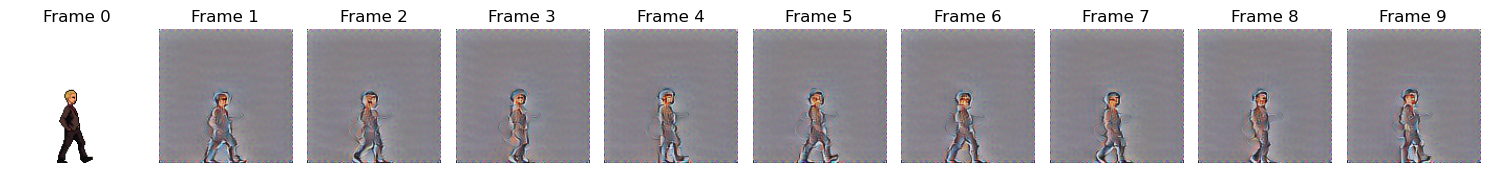

In [15]:
display_predicted_frames(merged_frames)

In [16]:
animate_frames(merged_frames)

In [17]:
img_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"
input_img = Image.open(image_path).convert('RGB').resize((128, 128))
input_img = np.array(input_img)
input_img.shape

(128, 128, 3)

In [18]:
# saving gif file

def animate_frames(predicted_frames, save_path=None, fps=5):
    """
    Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
    fps (int, optional): Frames per second for the animation. Default is 5 fps.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
    )

    if save_path:
        # Save the animation
        if save_path.endswith(".mp4"):
            ani.save(save_path, writer="ffmpeg", fps=fps)
        elif save_path.endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps)
        print(f"Animation saved to {save_path}")
    
    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())

animate_frames(merged_frames, '/Users/lofichill/Desktop/NIPA/project/test_frames/VGG_3.gif', fps=5)

Animation saved to /Users/lofichill/Desktop/NIPA/project/test_frames/VGG_3.gif
